In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [2]:
import json
import numpy as np
import pandas as pd

# Caminhos dos arquivos
caminho_json = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\cejusc_14052025\dados_processos_cejusc_14052025_V1_enriquecidos.json"
caminho_embeddings = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\Embeddings\dados_processos_cejusc_14052025_V1_enriquecidos_Embeddings.npy"

# Carregar JSON
with open(caminho_json, 'r', encoding='utf-8') as f:
    dados = json.load(f)

df = pd.DataFrame(dados)

# Carregar embeddings
vetores_texto = np.load(caminho_embeddings)

# Alinhar número de linhas
df = df.iloc[:vetores_texto.shape[0]]

In [3]:
prefixos = ("tem_", "n_", "tipo_", "cita_", "pede_", "houve_", "tentou_", "usa_", "problema_", "citou_")

colunas_struct = [col for col in df.columns if col.startswith(prefixos)]
cat_cols = [col for col in colunas_struct if df[col].dtype == 'object']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

colunas_struct_final = [col for col in df.columns if col.startswith(prefixos)]
X_struct = df[colunas_struct_final].fillna(0).astype(float).values

In [4]:
# Vetores combinados
X = np.hstack((vetores_texto, X_struct))

# Rótulo binário
y = df["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, matthews_corrcoef,
    classification_report, confusion_matrix
)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Instanciar modelo
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predição
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Métricas
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))
print("MCC:", matthews_corrcoef(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.77      0.66      1247
           1       0.49      0.29      0.36       964

    accuracy                           0.56      2211
   macro avg       0.54      0.53      0.51      2211
weighted avg       0.54      0.56      0.53      2211

Accuracy: 0.5608322026232474
F1-score: 0.3649444081098757
AUC: 0.5525672402146895
MCC: 0.06829366935606251


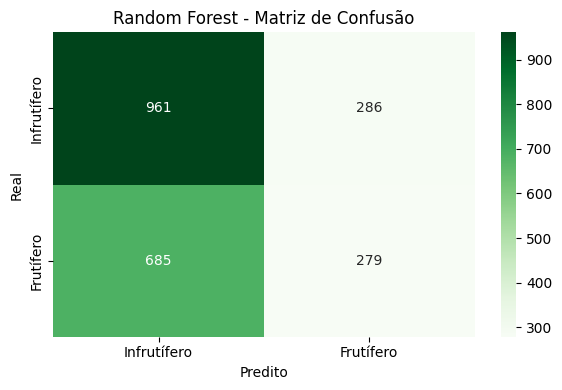

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Infrutífero", "Frutífero"],
            yticklabels=["Infrutífero", "Frutífero"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Random Forest - Matriz de Confusão")
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='f1')
print("F1 médio (5-fold):", cv_scores.mean())

F1 médio (5-fold): 0.3425728096059727


In [9]:
import joblib
joblib.dump(rf, r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\Notebooks\Random-Forest\modelo_rf_classificacao.pkl")
print("Modelo salvo como 'modelo_rf_classificacao.pkl'")

Modelo salvo como 'modelo_rf_classificacao.pkl'


Inferência

In [ ]:
import json
import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# -----------------------------
# CAMINHOS
# -----------------------------
caminho_json_novo = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\cejusc_03072025\dados_processos_cejusc_03072025_V1_enriquecidos.json"
caminho_embeddings_novo = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\dados\Embeddings\dados_processos_cejusc_03072025_V1_enriquecidos_Embeddings.npy"
caminho_modelo = r"C:\Users\Willgnner\Documents\TJ-GO\Perfil-Conciliação-Xgboost-GCP-V2\Notebooks\XGBoost\modelo_classificacao_xgb.pkl"  # Ou o XGBoost, se preferir

# -----------------------------
# CARGA DOS DADOS
# -----------------------------
with open(caminho_json_novo, 'r', encoding='utf-8') as f:
    dados = json.load(f)

df_novo = pd.DataFrame(dados)
vetores_novos = np.load(caminho_embeddings_novo)
df_novo = df_novo.iloc[:vetores_novos.shape[0]]

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------
prefixos = ("tem_", "n_", "tipo_", "cita_", "pede_", "houve_", "tentou_", "usa_", "problema_", "citou_")
colunas_struct = [col for col in df_novo.columns if col.startswith(prefixos)]
cat_cols = [col for col in colunas_struct if df_novo[col].dtype == 'object']
df_novo = pd.get_dummies(df_novo, columns=cat_cols, drop_first=True)
colunas_struct_final = [col for col in df_novo.columns if col.startswith(prefixos)]
X_struct_novo = df_novo[colunas_struct_final].fillna(0).astype(float).values
X_novo = np.hstack((vetores_novos, X_struct_novo))

# -----------------------------
# INFERÊNCIA
# -----------------------------
modelo = joblib.load(caminho_modelo)
y_pred = modelo.predict(X_novo)

# -----------------------------
# AVALIAÇÃO (se rótulo real existir!)
# -----------------------------
if "classificacao" in df_novo.columns:
    y_true = df_novo["classificacao"].map({'frutifero': 1, 'infrutifero': 0}).values

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    total_erros = (y_true != y_pred).sum()

    print(f"Avaliação na nova base:")
    print(f"  - Acurácia:      {acc:.4f}")
    print(f"  - Precisão:      {prec:.4f}")
    print(f"  - Recall:        {rec:.4f}")
    print(f"  - F1-score:      {f1:.4f}")
    print(f"  - Total de erros: {total_erros} / {len(y_true)}")

else:
    print("A coluna 'classificacao' não existe nos dados! Não é possível calcular métricas.")

Avaliação na nova base:
  - Acurácia:      0.5587
  - Precisão:      0.5179
  - Recall:        0.3861
  - F1-score:      0.4424
  - Total de erros: 1495 / 3388
